# Implementing L1Offset in coffea

In [1]:
import coffea
from coffea import hist, processor
from coffea.analysis_objects import JaggedCandidateArray
import time
import uproot
import uproot_methods
import awkward
import numpy as np
import coffea.hist as hist
from scipy import stats

from scipy.ndimage.interpolation import shift
from scipy import ndimage
from numba import jit
import pandas as pd

from calcOffset import *

In [2]:
etabins=np.array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839, -3.664, -3.489, -3.314, -3.139, -2.964,
         -2.853, -2.65, -2.5, -2.322, -2.172, -2.043, -1.93, -1.83, -1.74, -1.653, -1.566, -1.479, -1.392, -1.305,
         -1.218, -1.131, -1.044, -0.957, -0.879, -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
         -0.087, 0, 0.087, 0.174, 0.261, 0.348, 0.435, 0.522, 0.609, 0.696, 0.783, 0.879, 0.957, 1.044, 1.131,
         1.218, 1.305, 1.392, 1.479,1.566, 1.653, 1.74, 1.83, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853, 2.964,
         3.139, 3.314, 3.489, 3.664, 3.839, 4.013, 4.191, 4.363, 4.538, 4.716, 4.889, 5.191])
nEta = 82
etaC=0.5*(etabins[:-1]+etabins[1:])

#### getWeights function included in cacOffset to calculate the weights for MC histograms.
It takes the data and MC TTree as input and calculates the weights by taking the ratio of the pileup profiles and normalising it to have max value 1. These weights are applied only to MC histograms to reweight the MC wrt Data.

In [3]:
class Histomaker(processor.ProcessorABC):
    def __init__(self, weights=[]):
        self.R = 0.4
        self.mucut = 0
        self._weights = weights
        self.MAXNPV = 100
        self.MAXNPU = 100
        self.MAXRHO = 100
        self.nEta = 82
        self.etabins = np.array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839, -3.664,-3.489, -3.314, -3.139, -2.964,
                                 -2.853, -2.65, -2.5, -2.322, -2.172, -2.043, -1.93, -1.83, -1.74, -1.653, -1.566, -1.479, -1.392, -1.305,
                                 -1.218, -1.131, -1.044, -0.957, -0.879, -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
                                 -0.087, 0, 0.087, 0.174, 0.261, 0.348,0.435, 0.522, 0.609, 0.696, 0.783, 0.879, 0.957, 1.044, 1.131,1.218,
                                 1.305, 1.392, 1.479,1.566, 1.653, 1.74, 1.83, 1.93, 2.043, 2.172,2.322, 2.5, 2.65, 2.853, 2.964, 3.139,
                                 3.314, 3.489, 3.664, 3.839, 4.013, 4.191, 4.363, 4.538, 4.716, 4.889, 5.191])
        dataset_axis = hist.Cat("dataset", "Dataset")
        flavor_axis = hist.Cat("flavor", "PF Flavor")
        nPU_axis = hist.Bin("nPU", "mu", 2*self.MAXNPU, 0, self.MAXNPU)
        nPV_axis = hist.Bin("nPV", "nPV", 2*self.MAXNPV, 0, self.MAXNPV)
        rho_axis = hist.Bin("rho", "rho", 2*self.MAXRHO, 0, self.MAXRHO)
        eta_axis = hist.Bin("eta", "eta", self.etabins) 
        
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nPU": hist.Hist("Events", dataset_axis, nPU_axis ),
            "nPV": hist.Hist("Events", dataset_axis, nPV_axis),
            "rho": hist.Hist("Events", dataset_axis, rho_axis),
            
            "p_nPV_nPU": hist.Hist("Events", dataset_axis, nPU_axis ),
            "p_rho_nPU": hist.Hist("Events", dataset_axis, nPU_axis ),
            
            "p_offsetpT_geo_eta_nPU_flavor": hist.Hist("Events", dataset_axis, flavor_axis, nPU_axis,  eta_axis),
            "h_offsetpT_eta_nPU_flavor": hist.Hist("Events", dataset_axis, flavor_axis, nPU_axis,  eta_axis),
            "p_offsetpT_eta_nPU_flavor": hist.Hist("Events", dataset_axis, flavor_axis, nPU_axis,  eta_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        output["sumw"][dataset] += df.size

        mu = df['mu']
        rho = df['rho']
        nPV = df['nPV']
        
        weight = np.ones_like(mu)
        if (dataset=='MC'):
            index = np.digitize(mu,np.linspace(0,self.MAXNPU, num=2*self.MAXNPU+1))
            weight = weights[index-1]
            
        output["nPU"].fill(dataset=dataset, nPU=mu.flatten(), weight=weight)
        output["nPV"].fill(dataset=dataset, nPV=nPV.flatten(), weight=weight)
        output["rho"].fill(dataset=dataset, rho=rho.flatten(), weight=weight)
        output["p_nPV_nPU"].fill(dataset=dataset, nPU=mu.flatten(), weight=weight*nPV.flatten())
        output["p_rho_nPU"].fill(dataset=dataset, nPU=mu.flatten(), weight=weight*rho.flatten())

        energy = df['energy']
        ids = ['nh', 'ne','chm', 'chu', 'hfh', 'hfe', 'lep', 'untrk']
        
        ## Calculating RC and geometric offset - output shape is (100,82) for each particle type.
        for i in range(len(ids)):
            geo_offset = calcGeometricOffset(self.R, energy, df['f'+ids[i]], mu, self.mucut)
            rc_offset = calcOffsetRC(self.R, energy, df['f'+ids[i]])
            for ieta in range(self.nEta):            
                rc_weight_offset = rc_offset[:,ieta]*weight
                weight_offset = geo_offset[:,ieta]*weight
                output["h_offsetpT_eta_nPU_flavor"].fill(dataset=dataset, flavor=ids[i],
                                                         nPU=mu.flatten(), eta=etaC[ieta],
                                                         weight = weight)
                output["p_offsetpT_eta_nPU_flavor"].fill(dataset=dataset, flavor=ids[i],
                                                         nPU=mu.flatten(), eta=etaC[ieta],
                                                         weight=rc_weight_offset)
                output["p_offsetpT_geo_eta_nPU_flavor"].fill(dataset=dataset, flavor=ids[i],
                                                             nPU=mu.flatten(), eta=etaC[ieta],
                                                             weight=weight_offset)
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
datafile='../../OffsetUL17_withJEC/Total_Data_UL2017_skimmed.root'
mcfile='../../OffsetUL17_withJEC/Total_MC_UL2017_skimmed.root'

In [5]:
data = uproot.open(datafile)["T"]
MC = uproot.open(mcfile)["T"]

weights = getWeights(data, MC)

fileset = {
    'Data': [datafile],
    'MC': [mcfile]
}

output = processor.run_uproot_job(
    fileset,
    treename="T",
    processor_instance=Histomaker(weights=weights),
    executor=processor.futures_executor,
    executor_args={'workers':4},
    chunksize=10000#, maxchunks=1
)

Time:  0.025002479553222656


/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/calcOffset.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ratio = np.where(h_weights_mc>0, h_weights/h_weights_mc, 0)
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/calcOffset.py:19: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.where(h_weights_mc>0, h_weights/h_weights_mc, 0)


/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/calcOffset.py:42: RuntimeWarning: invalid value encountered in arccos
  A1 = np.where(d1<=rCone, 0.5*rCone*rCone*(2*np.arccos(d1/rCone) - np.sin(2*np.arccos(d1/rCone))), 0 )
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/calcOffset.py:43: RuntimeWarning: invalid value encountered in arccos
  A2 = np.where(d2<=rCone, 0.5*rCone*rCone*(2*np.arccos(d2/rCone) - np.sin(2*np.arccos(d2/rCone))), 0 )
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/calcOffset.py:51: RuntimeWarning: invalid value encountered in true_divide
  dphi = np.where(dphi > 1e-6, np.sin(dphi)/dphi, 1)
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/calcOffset.py:42: RuntimeWarning: invalid value encountered in arccos
  A1 = np.where(d1<=rCone, 0.5*rCone*rCone*(2*np.arccos(d1/rCone) - np.sin(2*np.arccos(d1/rCone))), 0 )
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/calcOffset.py:42: RuntimeWarning: invalid value encountered in arccos
  A1 = np.where(d1<=rCone, 0.5*rCone*rCone*(2*np.a

## Pileup Observables
Below are the plots for histograms and profiles of three important Pileup observables
These have all been scaled such that the area under the curves is 1.

In [6]:
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
plt.rc('font', family='serif')
from plotting import *

In [7]:
plt.rcParams['figure.dpi'] = 120

/eos/user/g/gagarwal/.local/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/eos/user/g/gagarwal/.local/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/eos/user/g/gagarwal/.local/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


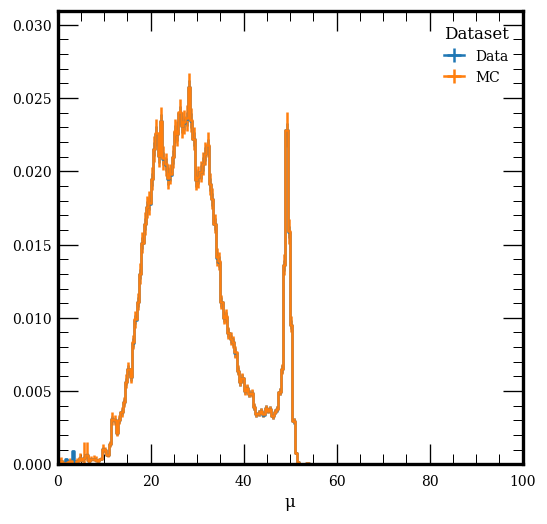

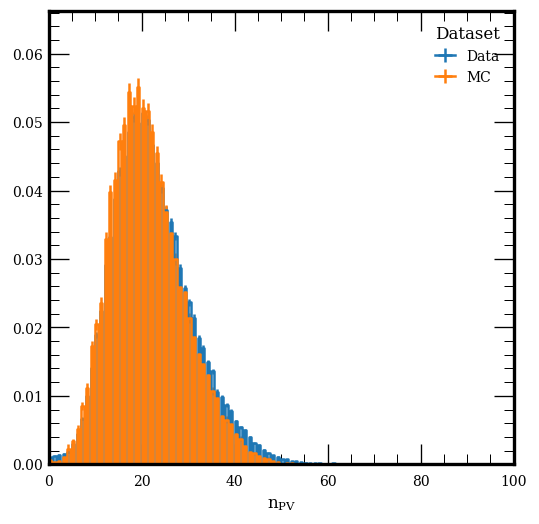

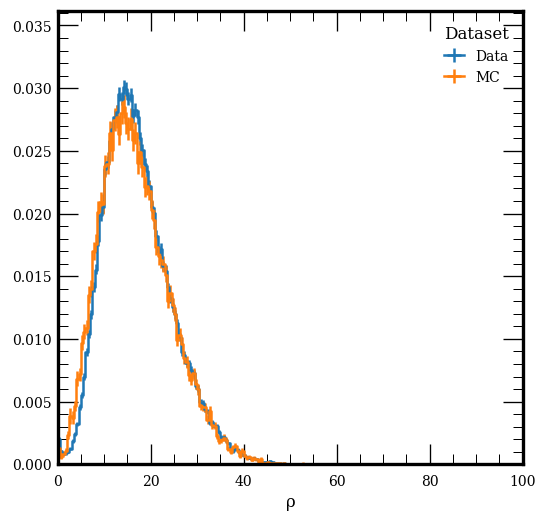

In [8]:
plotHist(output, 'nPU', r'$\mu$')
plotHist(output, 'nPV', r'$n_{PV}$')
plotHist(output, 'rho', r'$\rho$')

/eos/user/g/gagarwal/.local/lib/python3.6/site-packages/coffea/hist/plot.py:359: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/eos/user/g/gagarwal/.local/lib/python3.6/site-packages/coffea/hist/plot.py:366: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:871: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:68: RuntimeWarning: divide by zero encountered in true_divide
  im = rax.scatter(bin_center,(num1.values()[()]*denom2.values()[()])/(num2.values()[()]*denom1.values()[()]),
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:68: RuntimeWarning: invalid value encountered in true_divide
  im = rax.scatter(bin_c

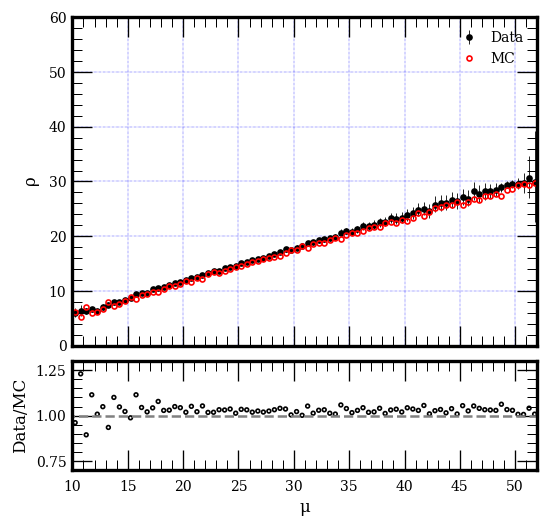

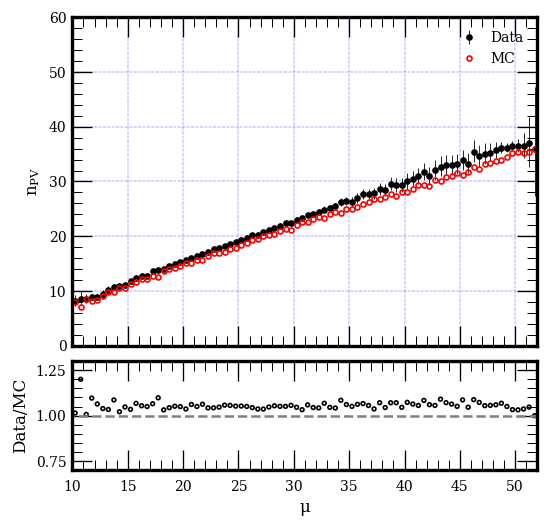

In [9]:
plotProfile(output, 'nPU', 'p_rho_nPU', 10, 52, r'$\mu$', r'$\rho$')
plotProfile(output, 'nPU', 'p_nPV_nPU', 10, 52, r'$\mu$', r'$n_{PV}$')

In [10]:
plt.rcParams['figure.dpi'] = 120

-0.087 - 0.0
3.314 - 3.489
-0.087 - 0.0


/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:98: RuntimeWarning: divide by zero encountered in true_divide
  im = ax.scatter(bin_center, (offset_v_eta_data.values()[()]* (1/norm_data)), label='Data', s=15, facecolors='k', edgecolors='k')
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:98: RuntimeWarning: invalid value encountered in multiply
  im = ax.scatter(bin_center, (offset_v_eta_data.values()[()]* (1/norm_data)), label='Data', s=15, facecolors='k', edgecolors='k')
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:99: RuntimeWarning: divide by zero encountered in true_divide
  im = ax.scatter(bin_center, (offset_v_eta_mc.values()[()]* (1/norm_mc)), label='MC', s=15, facecolors='none', edgecolors='r')
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:99: RuntimeWarning: invalid value encountered in multiply
  im = ax.scatter(bin_center, (offset_v_eta_mc.values()[()]* (1/norm_mc)), label='MC', s=15, facecolors='none', edgecolors='r')
/eos/home-

3.314 - 3.489


(array([-3.09903473e-04,  4.04853094e-01,  2.80713423e-01]),
 array([-2.20454959e-04,  3.49170173e-01,  1.22555261e-01]))

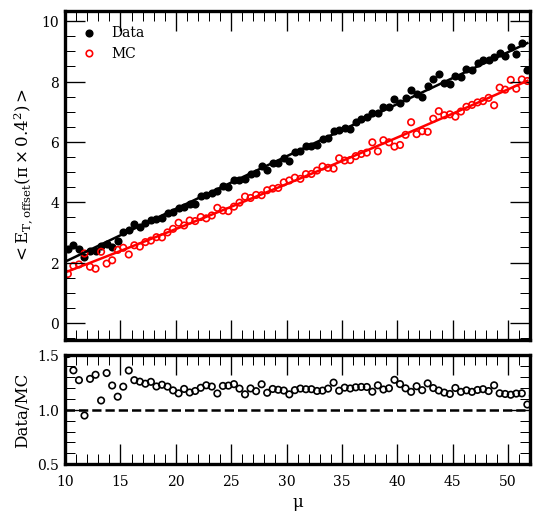

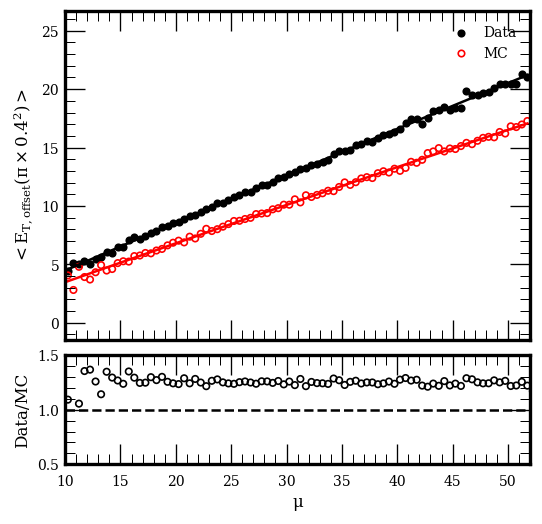

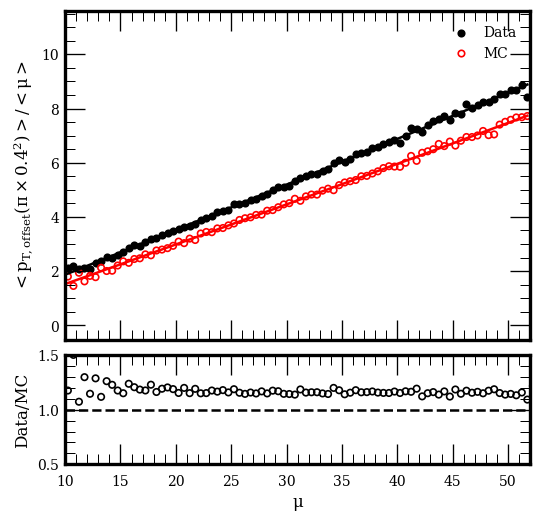

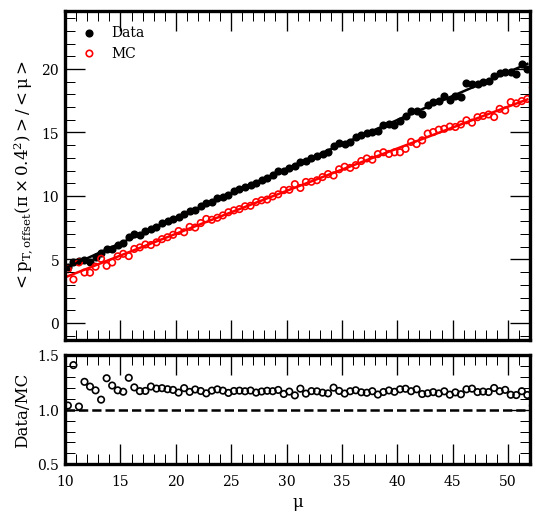

In [11]:
fitProfile(output, 'nPU', 'p_offsetpT_geo_eta_nPU_flavor', 'h_offsetpT_eta_nPU_flavor',
           r'$\mu$', r"$<E_{T,offset}(\pi \times 0.4^{2})>$", 40)
fitProfile(output, 'nPU', 'p_offsetpT_geo_eta_nPU_flavor', 'h_offsetpT_eta_nPU_flavor',
           r'$\mu$', r"$<E_{T,offset}(\pi \times 0.4^{2})>$", 72)
fitProfile(output, 'nPU', 'p_offsetpT_eta_nPU_flavor', 'h_offsetpT_eta_nPU_flavor',
           r'$\mu$', r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$", 40)
fitProfile(output, 'nPU', 'p_offsetpT_eta_nPU_flavor', 'h_offsetpT_eta_nPU_flavor',
           r'$\mu$', r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$", 72)

/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:166: RuntimeWarning: divide by zero encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:166: RuntimeWarning: invalid value encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
No handles with labels found to put in legend.
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:170: RuntimeWarning: invalid value encountered in true_divide
  r_hfh_l = np.where(m_hfh_l>1e-5, d_hfh_l/m_hfh_l, 0)
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:171: RuntimeWarning: invalid value encountered in true_divide
  r_hfe_l = np.where(m_hfe_l>1e-5, d_hfe_l/m_hfe_l, 0)
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:172: RuntimeWarning: invalid value encountered in true_divide
  r_hfh_r = np.where(m_hfh_r>1e-5, d_hfh_r/m_hfh_r, 0)
/eos/home-g/gagarwal/SWAN_projects/JEC-coffea/plotting.py:173: RuntimeWarning: invalid value 

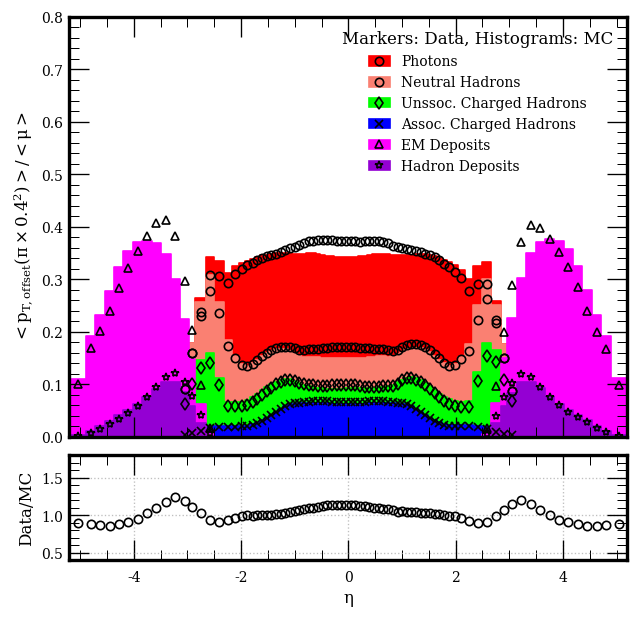

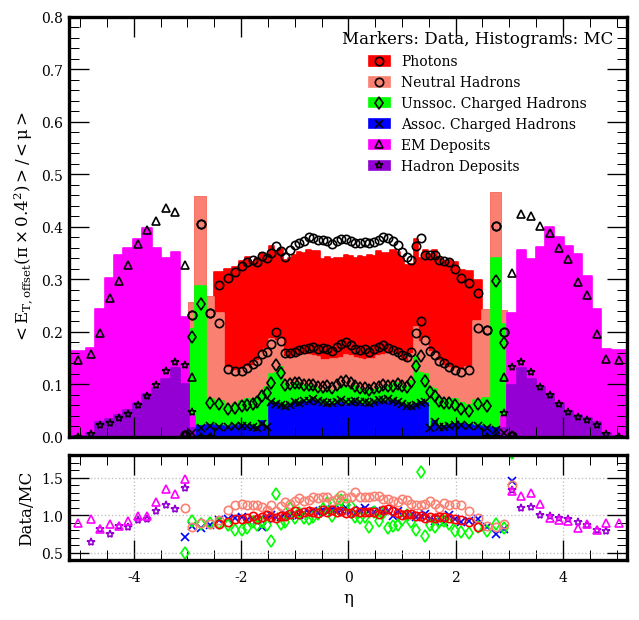

In [12]:
plotStack(output, 'eta', 'p_offsetpT_eta_nPU_flavor', 'nPU', 30, 31, r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'all', 0.8, False)
plotStack(output, 'eta', 'p_offsetpT_geo_eta_nPU_flavor', 'nPU', 30, 31, r"$<E_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'all', 0.8, True)

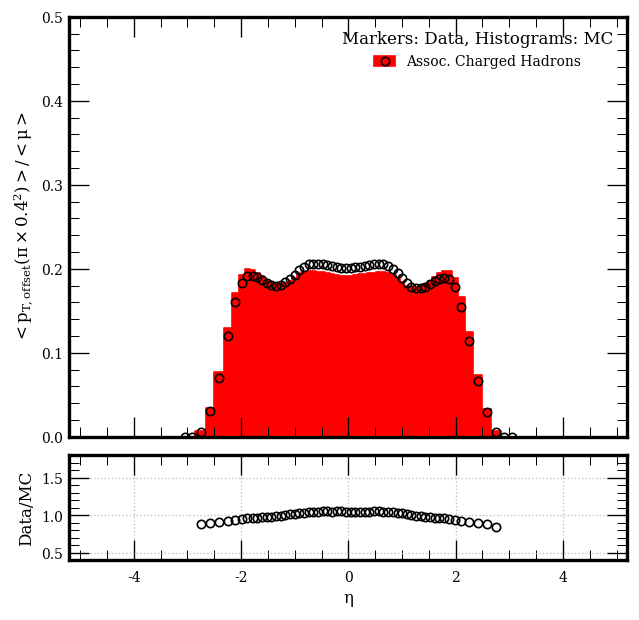

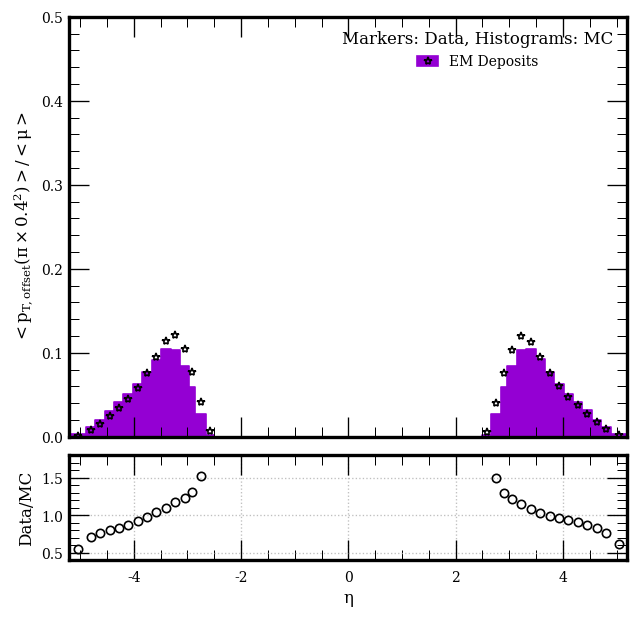

In [13]:
plotStack(output, 'eta', 'p_offsetpT_eta_nPU_flavor', 'nPU', 30, 31, r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'chm', 0.5, True)
plotStack(output, 'eta', 'p_offsetpT_eta_nPU_flavor', 'nPU', 30, 31, r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'hfe', 0.5, True)

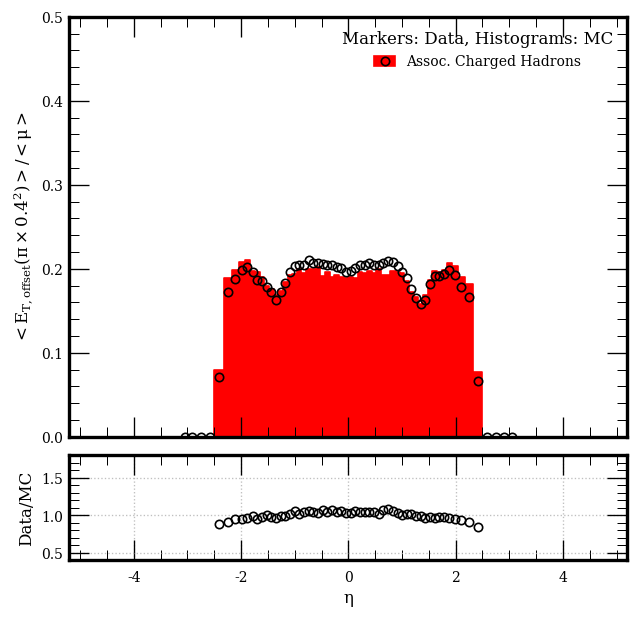

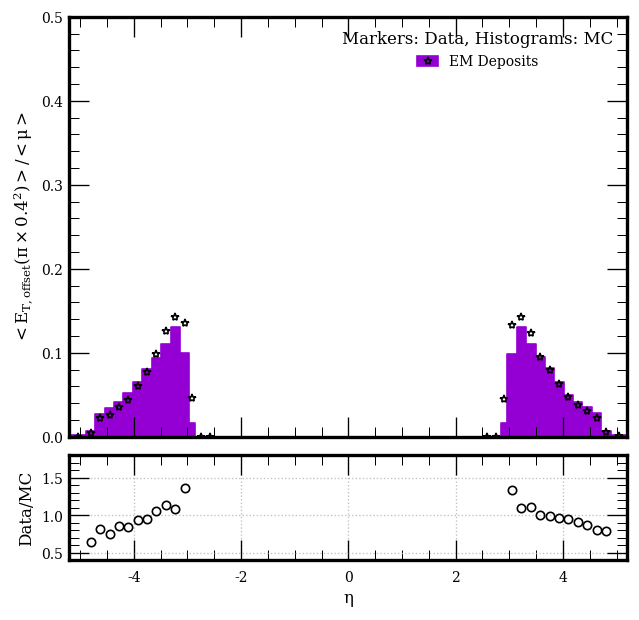

In [14]:
plotStack(output, 'eta', 'p_offsetpT_geo_eta_nPU_flavor', 'nPU', 30, 31, r"$<E_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'chm', 0.5, True)
plotStack(output, 'eta', 'p_offsetpT_geo_eta_nPU_flavor', 'nPU', 30, 31, r"$<E_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'hfe', 0.5, True)